# Optimal transport approximation via Sinkhorn iterations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

# Linear programming formulation

Suppose we have two non-negative denisties $f_i$, for $i = 1, 2, \cdots , m$, $g_j$ for $j = 1, 2, \cdots , n$ where 

$$\sum_i^m f_i = \sum_j^n g_j$$


on the unit interval $[0,1]$ with $c_{ij}$ the vector of distances between points $i$ and $j$. 

The we wish to find mapping $\pi_{ij}$ so that to minimise 

$$ \sum_i^m \sum_j^n c_{ij} \pi_{ij}$$

subject to 

$$\sum_j^n \pi_{ij} = f_i, \qquad \sum_i^m \pi_{ij} = g_y$$

where 

$$\pi_{ij} \geq 0.$$

In matrix form this is a standard linear programming 

$$\text{minimise } c_{ij} \cdot x$$

subject to 

$$Ax = b, \qquad \text{for} \qquad x \geq 0$$

where $A$ is the contraint matrix, $x$ is the mapping $\pi_{ij}$ and $b = [f_1, \cdots , f_m, g_1, \cdots, g_n]$.

# Sinkhorn Approximation

The problem with the LP formulation, the transport plan stores $N^2$ parameters, as well as the cost of solving the LP problem. The Sinkhorn-Knopp formulation addresses this problem. 

Instead we consider the regularised objective function where we add the negative entropy of the transport plan, 

$$ \sum_i^m \sum_j^n c_{ij} \pi_{ij} + \gamma\pi_{ij}(\log(\pi_{ij} - 1),$$

for some postive $\gamma$. For the constraints 

$$\sum_j^n \pi_{ij} = f_i, \qquad \sum_i^m \pi_{ij} = g_y$$

we consider the vector of ones $\mathbf 1\in\mathbb R^n$, and rewrite them as $\pi^T\mathbf 1 = f$ and $\pi\mathbf 1=g$, add Lagrange multipliers $\alpha$ and $\beta$ the the objective becomes

\begin{array}{rl}\mathcal{L}(\pi,\alpha,\beta) = & \sum_{i,j}\Big[c_{ij}\pi_{ij} + \pi_{ij}(\log(\pi_{ij}) -1)\Big]\\ & \quad+ \alpha^T(\pi^T{\mathbf 1}-f) + \beta^T(\pi{\mathbf 1}-g)\end{array} 

When taking the derivation of \mathcal{L}} w.r.t $\pi$,

$$\partial_{\pi_{i,j}}\mathcal{L} = c_{ij} + \gamma\log(\pi_{ij}) + \alpha_j + \beta_i = 0. $$

Solving for $\pi$ we get

$$\pi_{ij} = \exp\left(-\tfrac{c_{ij}}{\gamma}\right)\exp\left(-\tfrac{\alpha_j}\gamma\right)\exp\left(-\tfrac{\beta_i}\gamma\right).$$

So the optimal transport plan is given by the matrix

$$ M_{ij} = \exp(-\tfrac{c_{ij}}{\gamma}) $$

where its rows and columns are rescaled by vectors 
$$u_j = \exp\left(-\tfrac{\alpha_j}\gamma\right) \qquad \text{and} \qquad {v_i = \exp\left(-\tfrac{\beta_i}\gamma\right)}. $$ 

hence

$$\pi = \textit{diag}(v)M\textit{diag}(u).$$

This reduces storing $\pi$ for $N^2$ parameters to $2N$. If the cost depends only on the distance between points, e.g. $L^N$ distances, we can compute the cost on the fly to avoid storing the cost in memory. 

## Set up problem/regularisation

Sinkhorn distance: 0.015962846147842814


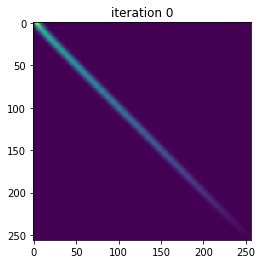

Sinkhorn distance: 0.3419498089536962


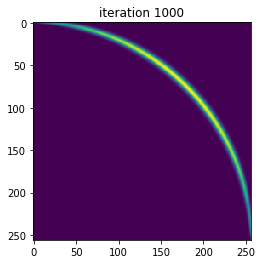

Sinkhorn distance: 0.34744219429245177


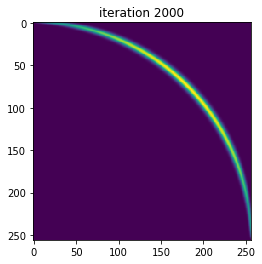

Sinkhorn distance: 0.3475043591357936


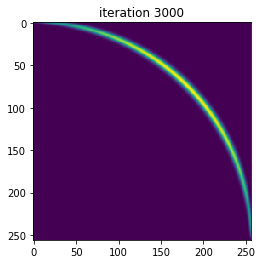

Sinkhorn distance: 0.3475050576739408


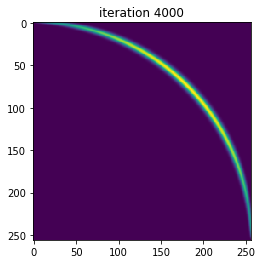

Sinkhorn distance: 0.3475050655226788


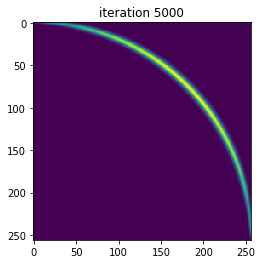

In [2]:
gamma = 0.0005
maxiters = 5001
 
n = 256

x = np.linspace(0,1,n)
c = np.linspace(0,1,n) # domain for cost

## test problem (dist = 1)

# source = np.zeros((n,1)) 
# target = np.zeros((n,1))
# source[0] = 1
# target[-1] = 1

source = 2*x
source = (source / np.sum(source)).reshape((source.shape[0],1))
target = 2 - 2*x
target = (target / np.sum(target)).reshape((target.shape[0],1))

i, j = np.meshgrid(c, c)
cost = pairwise_distances(x.reshape(-1,1), 
                         x.reshape(-1,1),
                         metric='sqeuclidean')
M = np.exp(-cost/gamma)

mu = np.ones((n,1))
nu = np.ones((n,1))

for k in range(maxiters):
    mu = np.divide(source, np.dot(M, nu))
    nu = np.divide(target, np.dot(M.T, mu))
    pi = np.dot(
        np.dot(
            np.diag(nu.reshape(-1)),
            M),
        np.diag(mu.reshape(-1))
    )
    
    sinkhorn_distance = np.sqrt(sum(sum(np.multiply(pi, cost))))
    
    if k % 1000 == 0: 
        print('Sinkhorn distance: ' + str(sinkhorn_distance))
        plt.imshow(np.divide(pi, pi.max()))
        plt.title('iteration ' + str(k))
        plt.show()